In [1]:
# !pip install nltk
# !pip install Sastrawi
# !pip install openpyxl
# !pip install swifter
# !pip install wordcloud


In [2]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import nltk
import string
import re
from sklearn.metrics.pairwise import cosine_similarity
from nltk.util import ngrams
import swifter

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

print('Loaded')

Loaded


C:\Users\dion\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_excel(
    "D:\Project gabut\Twitter sentiment analysis 'IKN'\Analisis Sentimen labelling.xlsx"
)
df.dropna(subset=["tweet"], inplace=True)
df["tweet"]

0       Nope. Baca dulu pasl 39 ayat 1 nya. Kedudukan ...
1       Kepres tentang penetapan Pemindahan IKN ini ya...
2       Perekonomian Indonesia akan tidak jawa sentris...
3       Bisakah kita menunda pemindahan IKN?krn skrg i...
4       Dukung Pemindahan IKN Nusantara Persiapan pemi...
                              ...                        
1980    Bngsa ini bukan milik yaman tapi milik aceh me...
1981    ngehibur diri atau lagi seneng krn ga jadi d p...
1982    ada akun x bercentang biru. punya follower rat...
1983    Rezim pencari loophole Anggota dpr gak mau pin...
1984    Kalau DPR kagak mau pindah ke IKN... itu cemen...
Name: tweet, Length: 1985, dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     1985 non-null   object
 1   sentimen  1985 non-null   object
dtypes: object(2)
memory usage: 31.1+ KB


In [5]:
df

,tweet,sentimen
0,Nope. Baca dulu pasl 39 ayat 1 nya. Kedudukan ...,positif
1,Kepres tentang penetapan Pemindahan IKN ini ya...,negatif
2,Perekonomian Indonesia akan tidak jawa sentris...,positif
3,Bisakah kita menunda pemindahan IKN?krn skrg i...,negatif
4,Dukung Pemindahan IKN Nusantara Persiapan pemi...,positif
...,...,...
1980,Bngsa ini bukan milik yaman tapi milik aceh me...,negatif
1981,ngehibur diri atau lagi seneng krn ga jadi d p...,negatif
1982,ada akun x bercentang biru. punya follower rat...,negatif
1983,Rezim pencari loophole Anggota dpr gak mau pin...,negatif


(array([1060.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         925.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

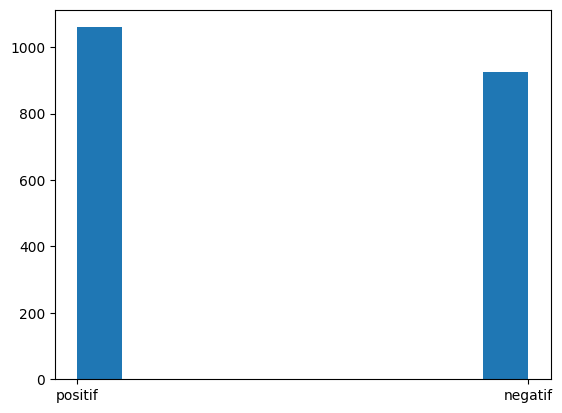

In [6]:
plt.hist(df.sentimen)

In [7]:
sentimen_counts = df["sentimen"].value_counts()
sentimen_counts

sentimen
positif    1060
negatif     925
Name: count, dtype: int64

In [8]:
def clean_df(text):
    if isinstance(text, str):
        text = re.sub("\[.*?\]", "", text)
        text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
        text = re.sub("\w*\d\w*", "", text)
        text = re.sub("\s+[a-zA-Z]\s+", "", text)
        text = re.sub(r"http\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"\B#\S+", "", text)
        text = re.sub(r"\s+", " ", text, flags=re.I)
        text = text.strip()
    return text

df["tweet"] = df["tweet"].astype(str)
df["CleanData"] = df["tweet"].apply(clean_df)
df

,tweet,sentimen,CleanData
0,Nope. Baca dulu pasl 39 ayat 1 nya. Kedudukan ...,positif,Nope Baca dulu pasl ayat nya Kedudukan IKN tet...
1,Kepres tentang penetapan Pemindahan IKN ini ya...,negatif,Kepres tentang penetapan Pemindahan IKN ini ya...
2,Perekonomian Indonesia akan tidak jawa sentris...,positif,Perekonomian Indonesia akan tidak jawa sentris...
3,Bisakah kita menunda pemindahan IKN?krn skrg i...,negatif,Bisakah kita menunda pemindahan IKNkrn skrg in...
4,Dukung Pemindahan IKN Nusantara Persiapan pemi...,positif,Dukung Pemindahan IKN Nusantara Persiapan pemi...
...,...,...,...
1980,Bngsa ini bukan milik yaman tapi milik aceh me...,negatif,Bngsa ini bukan milik yaman tapi milik aceh me...
1981,ngehibur diri atau lagi seneng krn ga jadi d p...,negatif,ngehibur diri atau lagi seneng krn ga jadipind...
1982,ada akun x bercentang biru. punya follower rat...,negatif,ada akunbercentang biru punya follower ratusan...
1983,Rezim pencari loophole Anggota dpr gak mau pin...,negatif,Rezim pencari loophole Anggota dpr gak mau pin...


In [9]:
def case_folding(text):
    text = text.lower()
    return text

df["CaseFolding"] = df["CleanData"].apply(lambda x: case_folding(x))
df

,tweet,sentimen,CleanData,CaseFolding
0,Nope. Baca dulu pasl 39 ayat 1 nya. Kedudukan ...,positif,Nope Baca dulu pasl ayat nya Kedudukan IKN tet...,nope baca dulu pasl ayat nya kedudukan ikn tet...
1,Kepres tentang penetapan Pemindahan IKN ini ya...,negatif,Kepres tentang penetapan Pemindahan IKN ini ya...,kepres tentang penetapan pemindahan ikn ini ya...
2,Perekonomian Indonesia akan tidak jawa sentris...,positif,Perekonomian Indonesia akan tidak jawa sentris...,perekonomian indonesia akan tidak jawa sentris...
3,Bisakah kita menunda pemindahan IKN?krn skrg i...,negatif,Bisakah kita menunda pemindahan IKNkrn skrg in...,bisakah kita menunda pemindahan iknkrn skrg in...
4,Dukung Pemindahan IKN Nusantara Persiapan pemi...,positif,Dukung Pemindahan IKN Nusantara Persiapan pemi...,dukung pemindahan ikn nusantara persiapan pemi...
...,...,...,...,...
1980,Bngsa ini bukan milik yaman tapi milik aceh me...,negatif,Bngsa ini bukan milik yaman tapi milik aceh me...,bngsa ini bukan milik yaman tapi milik aceh me...
1981,ngehibur diri atau lagi seneng krn ga jadi d p...,negatif,ngehibur diri atau lagi seneng krn ga jadipind...,ngehibur diri atau lagi seneng krn ga jadipind...
1982,ada akun x bercentang biru. punya follower rat...,negatif,ada akunbercentang biru punya follower ratusan...,ada akunbercentang biru punya follower ratusan...
1983,Rezim pencari loophole Anggota dpr gak mau pin...,negatif,Rezim pencari loophole Anggota dpr gak mau pin...,rezim pencari loophole anggota dpr gak mau pin...


In [10]:
def tokenization(text):
    text = re.split("\W+", text)
    return text

df["Tokenization"] = df["CaseFolding"].apply(lambda x: tokenization(x))
df

,tweet,sentimen,CleanData,CaseFolding,Tokenization
0,Nope. Baca dulu pasl 39 ayat 1 nya. Kedudukan ...,positif,Nope Baca dulu pasl ayat nya Kedudukan IKN tet...,nope baca dulu pasl ayat nya kedudukan ikn tet...,"[nope, baca, dulu, pasl, ayat, nya, kedudukan,..."
1,Kepres tentang penetapan Pemindahan IKN ini ya...,negatif,Kepres tentang penetapan Pemindahan IKN ini ya...,kepres tentang penetapan pemindahan ikn ini ya...,"[kepres, tentang, penetapan, pemindahan, ikn, ..."
2,Perekonomian Indonesia akan tidak jawa sentris...,positif,Perekonomian Indonesia akan tidak jawa sentris...,perekonomian indonesia akan tidak jawa sentris...,"[perekonomian, indonesia, akan, tidak, jawa, s..."
3,Bisakah kita menunda pemindahan IKN?krn skrg i...,negatif,Bisakah kita menunda pemindahan IKNkrn skrg in...,bisakah kita menunda pemindahan iknkrn skrg in...,"[bisakah, kita, menunda, pemindahan, iknkrn, s..."
4,Dukung Pemindahan IKN Nusantara Persiapan pemi...,positif,Dukung Pemindahan IKN Nusantara Persiapan pemi...,dukung pemindahan ikn nusantara persiapan pemi...,"[dukung, pemindahan, ikn, nusantara, persiapan..."
...,...,...,...,...,...
1980,Bngsa ini bukan milik yaman tapi milik aceh me...,negatif,Bngsa ini bukan milik yaman tapi milik aceh me...,bngsa ini bukan milik yaman tapi milik aceh me...,"[bngsa, ini, bukan, milik, yaman, tapi, milik,..."
1981,ngehibur diri atau lagi seneng krn ga jadi d p...,negatif,ngehibur diri atau lagi seneng krn ga jadipind...,ngehibur diri atau lagi seneng krn ga jadipind...,"[ngehibur, diri, atau, lagi, seneng, krn, ga, ..."
1982,ada akun x bercentang biru. punya follower rat...,negatif,ada akunbercentang biru punya follower ratusan...,ada akunbercentang biru punya follower ratusan...,"[ada, akunbercentang, biru, punya, follower, r..."
1983,Rezim pencari loophole Anggota dpr gak mau pin...,negatif,Rezim pencari loophole Anggota dpr gak mau pin...,rezim pencari loophole anggota dpr gak mau pin...,"[rezim, pencari, loophole, anggota, dpr, gak, ..."


In [11]:
text_stopword = pd.read_excel(
    "D:\Project gabut\Twitter sentiment analysis 'IKN'\Kamus\kamus_stopword.xlsx",
    names=["stopwords"],
    header=None,
)

list_stopwords = text_stopword["stopwords"].values.tolist()
list_stopwords = set(list_stopwords)

def stopwords_remove(words):
    return [word for word in words if word not in list_stopwords]

df["StopRemoval"] = df["Tokenization"].apply(stopwords_remove)
print(df["StopRemoval"].head())

0    [nope, baca, pasl, ayat, nya, kedudukan, ikn, ...
1                 [kepres, penetapan, pemindahan, ikn]
2    [perekonomian, indonesia, tidak, jawa, sentris...
3    [bisakah, kita, menunda, pemindahan, iknkrn, s...
4    [dukung, pemindahan, ikn, nusantara, persiapan...
Name: StopRemoval, dtype: object


In [12]:
final = pd.DataFrame(df, columns=["sentimen", "StopRemoval"])
final

,sentimen,StopRemoval
0,positif,"[nope, baca, pasl, ayat, nya, kedudukan, ikn, ..."
1,negatif,"[kepres, penetapan, pemindahan, ikn]"
2,positif,"[perekonomian, indonesia, tidak, jawa, sentris..."
3,negatif,"[bisakah, kita, menunda, pemindahan, iknkrn, s..."
4,positif,"[dukung, pemindahan, ikn, nusantara, persiapan..."
...,...,...
1980,negatif,"[bngsa, bukan, milik, yaman, milik, aceh, meda..."
1981,negatif,"[ngehibur, seneng, krn, ga, jadipindah, ikn, b..."
1982,negatif,"[akunbercentang, biru, follower, ratusan, ribu..."
1983,negatif,"[rezim, pencari, loophole, anggota, dpr, gak, ..."


In [13]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
    return stemmer.stem(term)
term_dict = {}

for document in final["StopRemoval"]:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ""
print(len(term_dict))
print("--------------------------------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term, ":", term_dict[term])
print(term_dict)
print("--------------------------------------------------")

def get_stemmed_term(document):
    return [term_dict[term] for term in document]

final["Stemming"] = final["StopRemoval"].apply(get_stemmed_term)

5905
--------------------------------------------------
nope : nope
baca : baca
pasl : pasl
ayat : ayat
nya : nya
kedudukan : duduk
ikn : ikn
jakarta : jakarta
keluarnya : keluar
keppres : keppres
pemindahan : pindah
terbit : terbit
yaa : yaa
kota : kota
jkt : jkt
ruu : ruu
dkj : dkj
bukan : bukan
dasar : dasar
hukum : hukum
pindahnya : pindah
nusantara : nusantara
pasca : pasca
iknðÿ : ikn
 : 
kepres : pres
penetapan : tetap
perekonomian : ekonomi
indonesia : indonesia
tidak : tidak
jawa : jawa
sentris : sentris
sedih : sedih
tau : tau
tinggal : tinggal
kalimantan : kalimantan
serba : serba
mahal : mahal
ngga : ngga
sebanding : banding
timur : timur
ruang : ruang
bisakah : bisa
kita : kita
menunda : tunda
iknkrn : iknkrn
skrg : skrg
murni : murni
ambisi : ambisi
tdk : tdk
lg : lg
nilai : nilai
kebaikan : baik
dlmâ : dlm
y : y
dukung : dukung
persiapan : siap
disiapkan : siap
matang : matang
perpindahan : pindah
sekedar : dar
memindahkan : pindah
fisik : fisik
perubahan : ubah
pola : p

In [14]:
kamus_asing = pd.read_excel(
    "D:\Project gabut\Twitter sentiment analysis 'IKN'\Kamus\kamus_normalisasi.xlsx"
)
kamus_asing

,Original,Replacement
0,abis,habis
1,ad,ada
2,ad,adalah
3,adlah,adalah
4,adlh,adalah
...,...,...
1635,yuk,ayo
1636,yup,iya
1637,yup,iya
1638,ywdh,ya sudah


In [15]:
normalized_word_dict = {}

for index, row in kamus_asing.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [
        normalized_word_dict[term] if term in normalized_word_dict else term
        for term in document
    ]

final["Normalisasi"] = final["Stemming"].apply(normalized_term)
final["Normalisasi"]

0       [nope, baca, pasal, ayat, nya, duduk, ikn, jak...
1                              [pres, tetap, pindah, ikn]
2       [ekonomi, indonesia, tidak, jawa, sentris, sed...
3       [bisa, kita, tunda, pindah, ikn karena, sekara...
4       [dukung, pindah, ikn, nusantara, siap, pindah,...
                              ...                        
1980    [bangsa, bukan, milik, yaman, milik, aceh, med...
1981    [ngehibur, neng, karena, tidak, jadipindah, ik...
1982    [akunbercentang, biru, follower, ratus, ribu, ...
1983    [rezim, cari, loophole, anggota, dpr, tidak, m...
1984    [dpr, tidak, mau, pindah, ikn, penakut, berleb...
Name: Normalisasi, Length: 1985, dtype: object

In [16]:
def fit_normalisasi(text):
    text = np.array(text)
    text = " ".join(text)

    return text

final["Normalisasi"] = final["Normalisasi"].apply(lambda x: fit_normalisasi(x))
final

,sentimen,StopRemoval,Stemming,Normalisasi
0,positif,"[nope, baca, pasl, ayat, nya, kedudukan, ikn, ...","[nope, baca, pasl, ayat, nya, duduk, ikn, jaka...",nope baca pasal ayat nya duduk ikn jakarta kel...
1,negatif,"[kepres, penetapan, pemindahan, ikn]","[pres, tetap, pindah, ikn]",pres tetap pindah ikn
2,positif,"[perekonomian, indonesia, tidak, jawa, sentris...","[ekonomi, indonesia, tidak, jawa, sentris, sed...",ekonomi indonesia tidak jawa sentris sedih tah...
3,negatif,"[bisakah, kita, menunda, pemindahan, iknkrn, s...","[bisa, kita, tunda, pindah, iknkrn, skrg, murn...",bisa kita tunda pindah ikn karena sekarang mur...
4,positif,"[dukung, pemindahan, ikn, nusantara, persiapan...","[dukung, pindah, ikn, nusantara, siap, pindah,...",dukung pindah ikn nusantara siap pindah ikn nu...
...,...,...,...,...
1980,negatif,"[bngsa, bukan, milik, yaman, milik, aceh, meda...","[bngsa, bukan, milik, yaman, milik, aceh, meda...",bangsa bukan milik yaman milik aceh medan pada...
1981,negatif,"[ngehibur, seneng, krn, ga, jadipindah, ikn, b...","[ngehibur, neng, krn, ga, jadipindah, ikn, ban...",ngehibur neng karena tidak jadipindah ikn bang...
1982,negatif,"[akunbercentang, biru, follower, ratusan, ribu...","[akunbercentang, biru, follower, ratus, ribu, ...",akunbercentang biru follower ratus ribu ngetwe...
1983,negatif,"[rezim, pencari, loophole, anggota, dpr, gak, ...","[rezim, cari, loophole, anggota, dpr, gak, mau...",rezim cari loophole anggota dpr tidak mau pind...


In [17]:
# from wordcloud import WordCloud

# neutral_words = " ".join(
#     [text for text in final["Normalisasi"][final["sentimen"] == "netral"]]
# )
# wordcloud = WordCloud(
#     width=800, height=500, random_state=0, max_font_size=110
# ).generate(neutral_words)
# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title("The Neutral Words")
# plt.show()

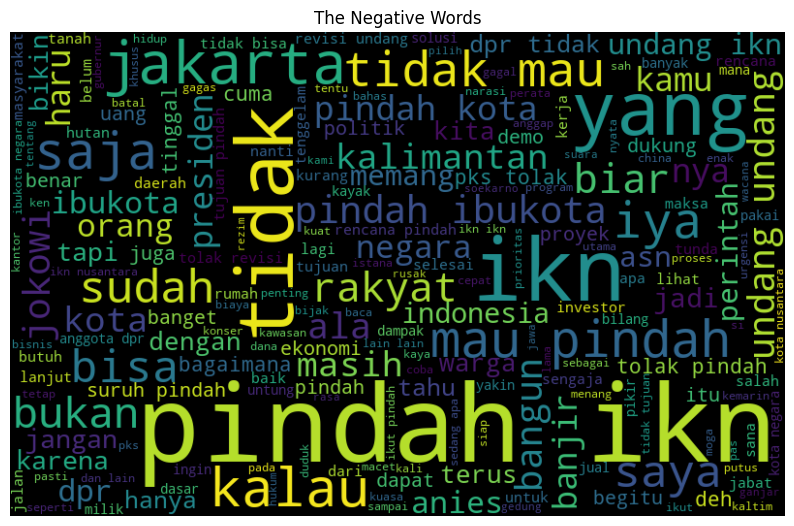

In [18]:
from wordcloud import WordCloud

negative_words = " ".join(
    [text for text in final["Normalisasi"][final["sentimen"] == "negatif"]]
)
wordcloud = WordCloud(
    width=800, height=500, random_state=0, max_font_size=110
).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Negative Words")
plt.show()

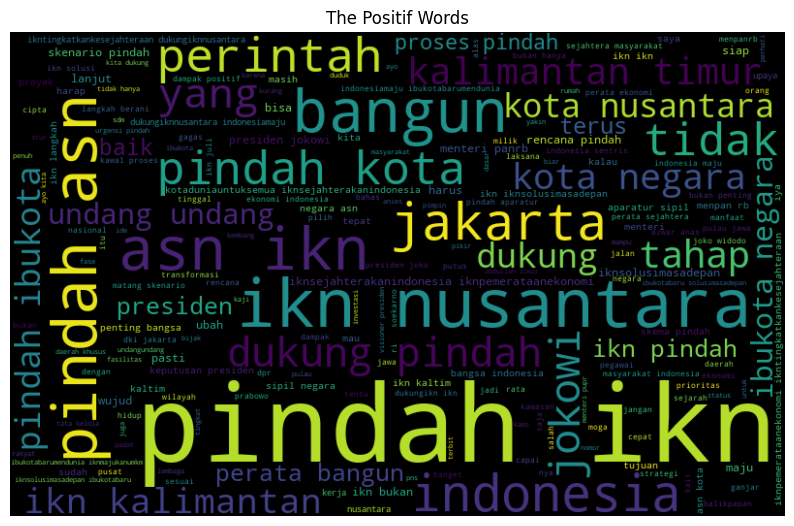

In [19]:
from wordcloud import WordCloud

positif_words = " ".join(
    [text for text in final["Normalisasi"][final["sentimen"] == "positif"]]
)

wordcloud = WordCloud(
    width=800, height=500, random_state=0, max_font_size=110
).generate(positif_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("The Positif Words")
plt.show()

In [20]:
# def convert(polarity):
#     if polarity == "netral":
#         return 0
#     elif polarity == "positif":
#         return 1
#     else:
#         return 2


def convert(polarity):
    if polarity == "positif":
        return 1
    else:
        return -1


final["Polarity"] = final["sentimen"].apply(convert)
final

,sentimen,StopRemoval,Stemming,Normalisasi,Polarity
0,positif,"[nope, baca, pasl, ayat, nya, kedudukan, ikn, ...","[nope, baca, pasl, ayat, nya, duduk, ikn, jaka...",nope baca pasal ayat nya duduk ikn jakarta kel...,1
1,negatif,"[kepres, penetapan, pemindahan, ikn]","[pres, tetap, pindah, ikn]",pres tetap pindah ikn,-1
2,positif,"[perekonomian, indonesia, tidak, jawa, sentris...","[ekonomi, indonesia, tidak, jawa, sentris, sed...",ekonomi indonesia tidak jawa sentris sedih tah...,1
3,negatif,"[bisakah, kita, menunda, pemindahan, iknkrn, s...","[bisa, kita, tunda, pindah, iknkrn, skrg, murn...",bisa kita tunda pindah ikn karena sekarang mur...,-1
4,positif,"[dukung, pemindahan, ikn, nusantara, persiapan...","[dukung, pindah, ikn, nusantara, siap, pindah,...",dukung pindah ikn nusantara siap pindah ikn nu...,1
...,...,...,...,...,...
1980,negatif,"[bngsa, bukan, milik, yaman, milik, aceh, meda...","[bngsa, bukan, milik, yaman, milik, aceh, meda...",bangsa bukan milik yaman milik aceh medan pada...,-1
1981,negatif,"[ngehibur, seneng, krn, ga, jadipindah, ikn, b...","[ngehibur, neng, krn, ga, jadipindah, ikn, ban...",ngehibur neng karena tidak jadipindah ikn bang...,-1
1982,negatif,"[akunbercentang, biru, follower, ratusan, ribu...","[akunbercentang, biru, follower, ratus, ribu, ...",akunbercentang biru follower ratus ribu ngetwe...,-1
1983,negatif,"[rezim, pencari, loophole, anggota, dpr, gak, ...","[rezim, cari, loophole, anggota, dpr, gak, mau...",rezim cari loophole anggota dpr tidak mau pind...,-1


In [21]:
final

,sentimen,StopRemoval,Stemming,Normalisasi,Polarity
0,positif,"[nope, baca, pasl, ayat, nya, kedudukan, ikn, ...","[nope, baca, pasl, ayat, nya, duduk, ikn, jaka...",nope baca pasal ayat nya duduk ikn jakarta kel...,1
1,negatif,"[kepres, penetapan, pemindahan, ikn]","[pres, tetap, pindah, ikn]",pres tetap pindah ikn,-1
2,positif,"[perekonomian, indonesia, tidak, jawa, sentris...","[ekonomi, indonesia, tidak, jawa, sentris, sed...",ekonomi indonesia tidak jawa sentris sedih tah...,1
3,negatif,"[bisakah, kita, menunda, pemindahan, iknkrn, s...","[bisa, kita, tunda, pindah, iknkrn, skrg, murn...",bisa kita tunda pindah ikn karena sekarang mur...,-1
4,positif,"[dukung, pemindahan, ikn, nusantara, persiapan...","[dukung, pindah, ikn, nusantara, siap, pindah,...",dukung pindah ikn nusantara siap pindah ikn nu...,1
...,...,...,...,...,...
1980,negatif,"[bngsa, bukan, milik, yaman, milik, aceh, meda...","[bngsa, bukan, milik, yaman, milik, aceh, meda...",bangsa bukan milik yaman milik aceh medan pada...,-1
1981,negatif,"[ngehibur, seneng, krn, ga, jadipindah, ikn, b...","[ngehibur, neng, krn, ga, jadipindah, ikn, ban...",ngehibur neng karena tidak jadipindah ikn bang...,-1
1982,negatif,"[akunbercentang, biru, follower, ratusan, ribu...","[akunbercentang, biru, follower, ratus, ribu, ...",akunbercentang biru follower ratus ribu ngetwe...,-1
1983,negatif,"[rezim, pencari, loophole, anggota, dpr, gak, ...","[rezim, cari, loophole, anggota, dpr, gak, mau...",rezim cari loophole anggota dpr tidak mau pind...,-1


In [22]:
# final.to_excel(r"E:\Wirda\After pre-processing.xlsx")

In [23]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(
    final["Normalisasi"], final["Polarity"], test_size=0.15, random_state=32
)

In [24]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [25]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(final["Normalisasi"])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [26]:
hyperparams = {"kernel": ("linear", "rbf"), "C": [1, 10]}
svm = SVC()
svm_tuned = GridSearchCV(svm, hyperparams)

In [27]:
svm_tuned.fit(Train_X_Tfidf, Train_Y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [28]:
svm = SVC(C=0.5, kernel="linear", degree=1, gamma="scale")
svm.fit(Train_X_Tfidf, Train_Y)

SVC(C=0.5, degree=1, kernel='linear')

In [29]:
filename = "model_svm_IKN.pkl"
pickle.dump(svm, open(filename, "wb"))

In [30]:
loaded_model = pickle.load(open(filename, "rb"))
result = loaded_model.score(Test_X_Tfidf, Test_Y)
print(result)

0.912751677852349


In [31]:
predict_test2 = svm.predict(Test_X_Tfidf)

print("SVM Accuracy Score = ", accuracy_score(predict_test2, Test_Y) * 100)
print(
    "SVM Precision Score = ", recall_score(predict_test2, Test_Y, average="macro") * 100
)
print(
    "SVM Recall Score = ", precision_score(predict_test2, Test_Y, average="macro") * 100
)
print("SVM f1 Score = ", f1_score(predict_test2, Test_Y, average="macro") * 100)

SVM Accuracy Score =  91.2751677852349
SVM Precision Score =  91.39329488103822
SVM Recall Score =  91.80014561339644
SVM f1 Score =  91.26099706744868


In [32]:
predict_test2 = svm.predict(Test_X_Tfidf)
report = classification_report(Test_Y, predict_test2)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       134
           1       0.97      0.87      0.92       164

    accuracy                           0.91       298
   macro avg       0.91      0.92      0.91       298
weighted avg       0.92      0.91      0.91       298



In [33]:
LR_model = LogisticRegression(solver="lbfgs")
LR_model.fit(Train_X_Tfidf, Train_Y)
y_predict_lr = LR_model.predict(Test_X_Tfidf)
print("LR Accuracy score: ", accuracy_score(Test_Y, y_predict_lr))

LR Accuracy score:  0.8926174496644296


In [34]:
predict_test3 = LR_model.predict(Test_X_Tfidf)

print("LR Accuracy Score = ", accuracy_score(predict_test2, Test_Y) * 100)
print(
    "LR Precision Score = ", recall_score(predict_test2, Test_Y, average="macro") * 100
)
print(
    "LR Recall Score = ", precision_score(predict_test2, Test_Y, average="macro") * 100
)
print("LR f1 Score = ", f1_score(predict_test2, Test_Y, average="macro") * 100)

LR Accuracy Score =  91.2751677852349
LR Precision Score =  91.39329488103822
LR Recall Score =  91.80014561339644
LR f1 Score =  91.26099706744868


In [35]:
predict_test3 = LR_model.predict(Test_X_Tfidf)
report = classification_report(Test_Y, predict_test3)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       134
           1       0.95      0.85      0.90       164

    accuracy                           0.89       298
   macro avg       0.89      0.90      0.89       298
weighted avg       0.90      0.89      0.89       298



In [36]:
def classify(tweet):
    pred = svm.predict(Tfidf_vect.transform([tweet]))
    if pred == 1:
        return "Positif"
    return "Negatif"

In [37]:
classify("IKN sukses")

'Positif'

In [38]:
classify('solusinya adalah bangun ikn')

'Positif'

In [39]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# 10 FOLD
scores_test = cross_val_score(svm, Test_X_Tfidf, Test_Y, cv=10)
print("Hasil Akurasi menggunakan 10 Fold Cross Validation \n")
for i in range(10):
    print(
        "Akurasi dari SVM Iterasi ke -",
        i + 1,
        "  : {0:2}".format(scores_test[i,] * 100),
    )
print(
    "\n",
    "Rata-Rata Akurasi dari SVM menggunakan Cross Validation :",
    scores_test.mean() * 100,
)

Hasil Akurasi menggunakan 10 Fold Cross Validation 

Akurasi dari SVM Iterasi ke - 1   : 90.0
Akurasi dari SVM Iterasi ke - 2   : 86.66666666666667
Akurasi dari SVM Iterasi ke - 3   : 86.66666666666667
Akurasi dari SVM Iterasi ke - 4   : 90.0
Akurasi dari SVM Iterasi ke - 5   : 96.66666666666667
Akurasi dari SVM Iterasi ke - 6   : 90.0
Akurasi dari SVM Iterasi ke - 7   : 76.66666666666667
Akurasi dari SVM Iterasi ke - 8   : 86.66666666666667
Akurasi dari SVM Iterasi ke - 9   : 75.86206896551724
Akurasi dari SVM Iterasi ke - 10   : 93.10344827586206

 Rata-Rata Akurasi dari SVM menggunakan Cross Validation : 87.22988505747126


In [40]:
# 10 FOLD - Precission

scores_test = cross_val_score(
    svm_tuned, Test_X_Tfidf, Test_Y, cv=10, scoring="precision"
)
scores_test
print("Hasil Presisi menggunakan 10 Fold Cross Validation \n")
for i in range(10):
    print(
        "Presisi dari SVM Iterasi ke -",
        i + 1,
        "  : {0:2}".format(scores_test[i,] * 100),
    )
print(
    "\n",
    "Rata-Rata Presisi dari SVM menggunakan Cross Validation :",
    scores_test.mean() * 100,
)

Hasil Presisi menggunakan 10 Fold Cross Validation 

Presisi dari SVM Iterasi ke - 1   : 93.33333333333333
Presisi dari SVM Iterasi ke - 2   : 86.66666666666667
Presisi dari SVM Iterasi ke - 3   : 87.5
Presisi dari SVM Iterasi ke - 4   : 92.85714285714286
Presisi dari SVM Iterasi ke - 5   : 100.0
Presisi dari SVM Iterasi ke - 6   : 93.75
Presisi dari SVM Iterasi ke - 7   : 80.0
Presisi dari SVM Iterasi ke - 8   : 100.0
Presisi dari SVM Iterasi ke - 9   : 82.35294117647058
Presisi dari SVM Iterasi ke - 10   : 93.75

 Rata-Rata Presisi dari SVM menggunakan Cross Validation : 91.02100840336135


In [41]:
# 10 FOLD - Recall

scores_test = cross_val_score(svm_tuned, Test_X_Tfidf, Test_Y, cv=10, scoring="recall")
scores_test
print("Hasil Recall menggunakan 10 Fold Cross Validation \n")
for i in range(10):
    print(
        "Recall dari SVM Iterasi ke -", i + 1, "  : {0:2}".format(scores_test[i,] * 100)
    )
print(
    "\n",
    "Rata-Rata Recall dari SVM menggunakan Cross Validation :",
    scores_test.mean() * 100,
)

Hasil Recall menggunakan 10 Fold Cross Validation 

Recall dari SVM Iterasi ke - 1   : 87.5
Recall dari SVM Iterasi ke - 2   : 81.25
Recall dari SVM Iterasi ke - 3   : 87.5
Recall dari SVM Iterasi ke - 4   : 81.25
Recall dari SVM Iterasi ke - 5   : 94.11764705882352
Recall dari SVM Iterasi ke - 6   : 88.23529411764706
Recall dari SVM Iterasi ke - 7   : 70.58823529411765
Recall dari SVM Iterasi ke - 8   : 76.47058823529412
Recall dari SVM Iterasi ke - 9   : 87.5
Recall dari SVM Iterasi ke - 10   : 93.75

 Rata-Rata Recall dari SVM menggunakan Cross Validation : 84.81617647058822


In [42]:
scores_test = cross_val_score(svm_tuned, Test_X_Tfidf, Test_Y, cv=10, scoring="f1")
scores_test
print("Hasil F1 Score menggunakan 10 Fold Cross Validation \n")
for i in range(10):
    print(
        "F1 Score dari SVM Iterasi ke -",
        i + 1,
        "  : {0:2}".format(scores_test[i,] * 100),
    )
print(
    "\n",
    "Rata-Rata F1 Score dari SVM menggunakan Cross Validation :",
    scores_test.mean() * 100,
)

Hasil F1 Score menggunakan 10 Fold Cross Validation 

F1 Score dari SVM Iterasi ke - 1   : 90.32258064516128
F1 Score dari SVM Iterasi ke - 2   : 83.87096774193549
F1 Score dari SVM Iterasi ke - 3   : 87.5
F1 Score dari SVM Iterasi ke - 4   : 86.66666666666666
F1 Score dari SVM Iterasi ke - 5   : 96.96969696969697
F1 Score dari SVM Iterasi ke - 6   : 90.9090909090909
F1 Score dari SVM Iterasi ke - 7   : 75.00000000000001
F1 Score dari SVM Iterasi ke - 8   : 86.66666666666666
F1 Score dari SVM Iterasi ke - 9   : 84.84848484848484
F1 Score dari SVM Iterasi ke - 10   : 93.75

 Rata-Rata F1 Score dari SVM menggunakan Cross Validation : 87.65041544477029
